# Speech Emotion Recognition

### https://www.kaggle.com/shivamburnwal/speech-emotion-recognition/notebook

### Importing libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2021-12-06 01:31:56.711032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-06 01:31:56.711080: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Ravdess Dataframe

In [2]:
# Paths for data.
Ravdess = "data/"

#Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [7]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    if not os.path.isdir(Ravdess + dir):
        continue
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head(15)

angry.wav
scared.wav
neutral.wav
surprised.wav


Emotions                                    Path
0   neutral  data/Actor_01/03-01-01-01-01-01-01.wav
1   neutral  data/Actor_01/03-01-01-01-01-02-01.wav
2   neutral  data/Actor_01/03-01-01-01-02-01-01.wav
3   neutral  data/Actor_01/03-01-01-01-02-02-01.wav
4      calm  data/Actor_01/03-01-02-01-01-01-01.wav
5      calm  data/Actor_01/03-01-02-01-01-02-01.wav
6      calm  data/Actor_01/03-01-02-01-02-01-01.wav
7      calm  data/Actor_01/03-01-02-01-02-02-01.wav
8      calm  data/Actor_01/03-01-02-02-01-01-01.wav
9      calm  data/Actor_01/03-01-02-02-01-02-01.wav
10     calm  data/Actor_01/03-01-02-02-02-01-01.wav
11     calm  data/Actor_01/03-01-02-02-02-02-01.wav
12    happy  data/Actor_01/03-01-03-01-01-01-01.wav
13    happy  data/Actor_01/03-01-03-01-01-02-01.wav
14    happy  data/Actor_01/03-01-03-01-02-01-01.wav

In [8]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                    Path
0  neutral  data/Actor_01/03-01-01-01-01-01-01.wav
1  neutral  data/Actor_01/03-01-01-01-01-02-01.wav
2  neutral  data/Actor_01/03-01-01-01-02-01-01.wav
3  neutral  data/Actor_01/03-01-01-01-02-02-01.wav
4     calm  data/Actor_01/03-01-02-01-01-01-01.wav

### Data Visualisation and Exploration

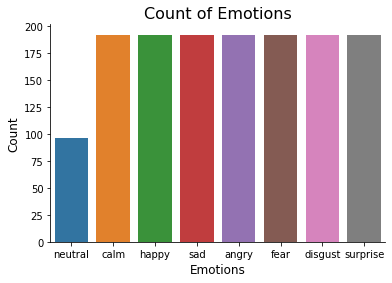

In [9]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Plotting waveplots and spectograms for audio signals

### Waveplots illustrates the loudness of the audio at a given time
### Spectograms are  a visual representation of the spectrum of frequencies of sound or other signals as they vary with time, it’s a representation of frequencies changing with respect to time for given audio/music signals.

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

Data from our voices

In [13]:
neutral_data, sampling_rate = librosa.load('data/neutral.wav')
scared_data, _ = librosa.load('data/scared.wav')
surprised_data, _ = librosa.load('data/surprised.wav')
angry_data, _ = librosa.load('data/angry.wav')

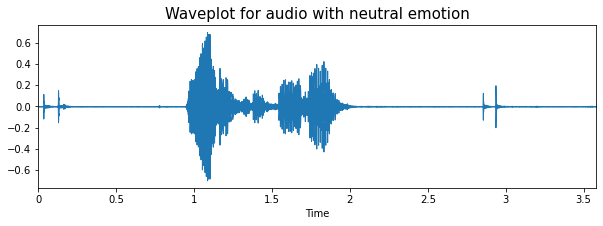

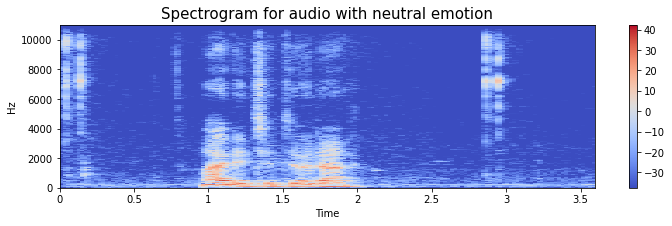

In [14]:
create_waveplot(neutral_data, sampling_rate, 'neutral')
create_spectrogram(neutral_data, sampling_rate, 'neutral')
Audio('data/neutral.wav')

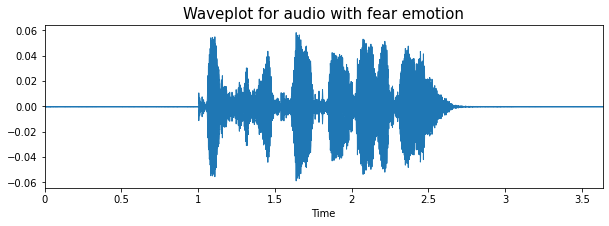

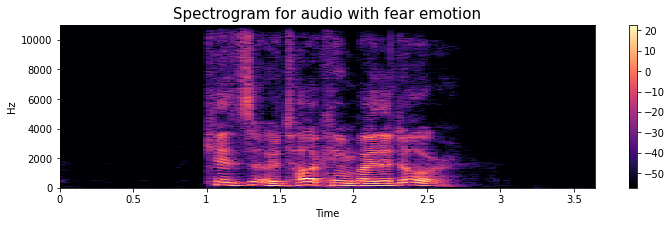

In [15]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

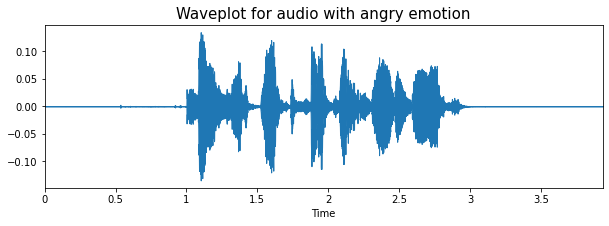

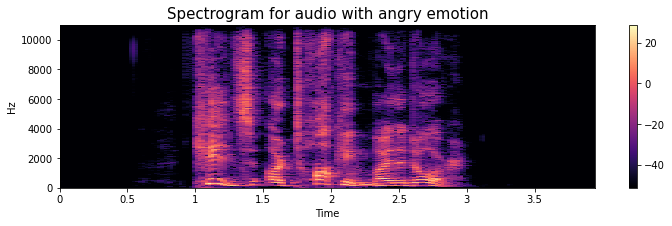

In [16]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

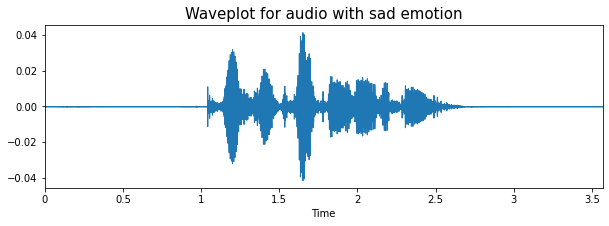

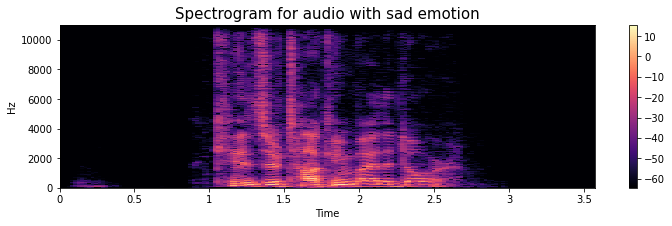

In [9]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

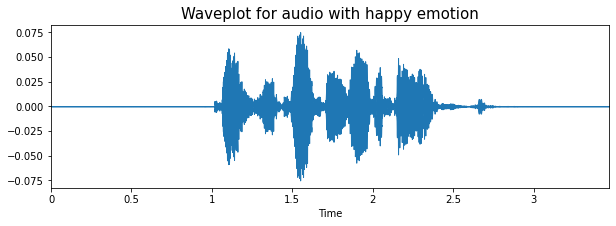

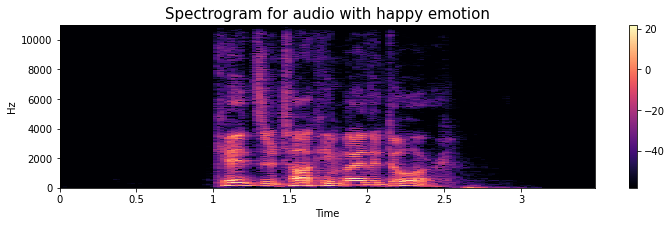

In [17]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

### Data Augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set

### To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed
### The objective is to make our model invariant to those perturbations and enhace its ability to generalize
### In order to this to work adding the perturbations must conserve the same label as the original training sample
### In images data augmention can be performed by shifting the image, zooming, rotating ...
### Checking which augmentation techniques works better for our dataset

In [18]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

### Simple audio

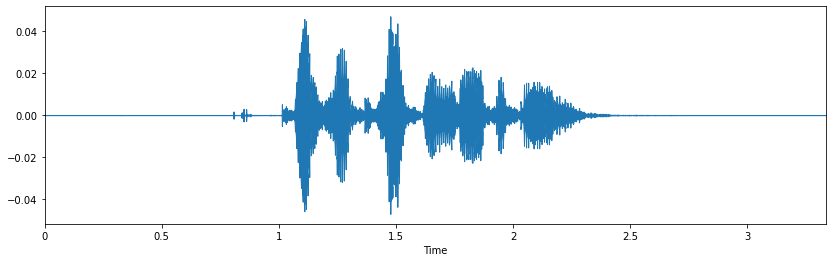

In [19]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

### Noise Injection is a very good augmentation technique because of which we can assure the training model is not overfitted

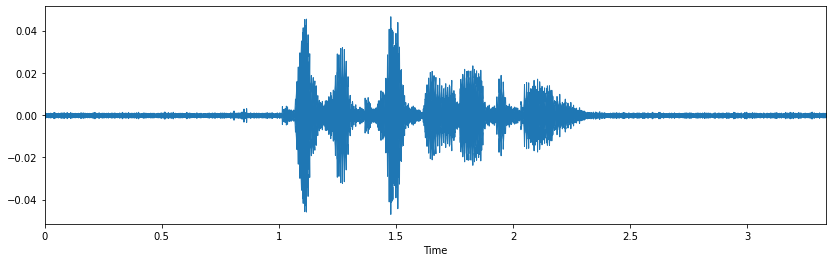

In [20]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

###  Stretching

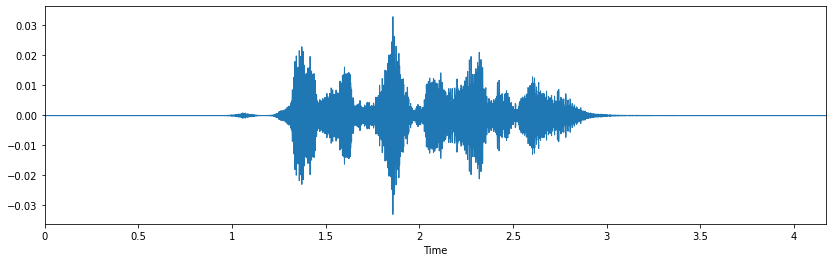

In [21]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Shifting

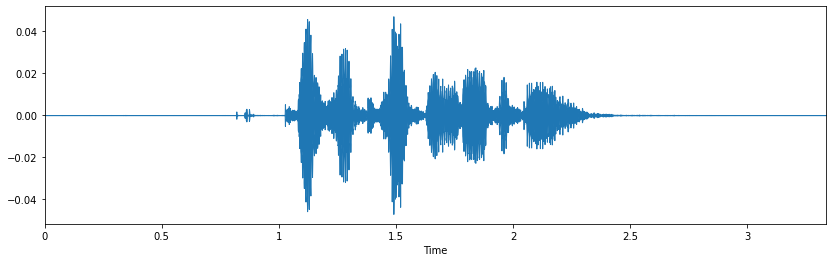

In [22]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Pitching

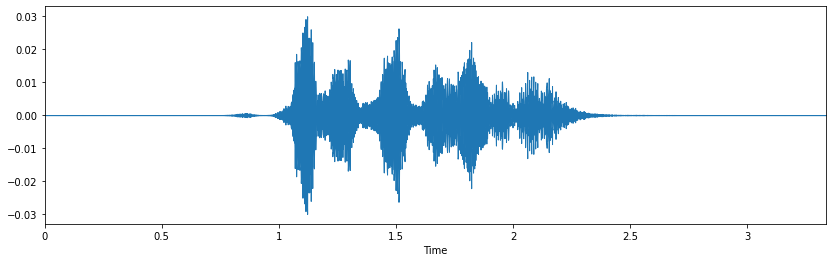

In [26]:
x = pitch(data, sample_rate, pitch_factor=1.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Feature Extraction

### Extracting 5 features:

### Zero Crossing Rate
### Chroma_stft
### MFCC
### RMS(root mean square) value
### MelSpectogram to train our model.

In [32]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    for pitch_factor in (-1.5, -.7, 1.5):
        new_data = pitch(data, sample_rate, pitch_factor=pitch_factor)
        res = extract_features(new_data)
        result = np.vstack((result, res))
    
    return result

### Normalizing and splitting the data for training and testing

In [28]:
neutral_res = extract_features(neutral_data)
scared_res = extract_features(scared_data)
angry_res = extract_features(angry_data)
surprised_res = extract_features(surprised_data)

In [35]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [36]:
len(X), len(Y), data_path.Path.shape

(8640, 8640, (1440,))

In [37]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.300781  0.706492  0.756853  0.735217  0.731014  0.715156  0.667529   
1  0.312943  0.753084  0.799150  0.806534  0.804417  0.814502  0.752583   
2  0.176678  0.640599  0.712793  0.743710  0.714789  0.701444  0.694581   
3  0.171771  0.720952  0.720561  0.687057  0.653217  0.666953  0.710900   
4  0.161680  0.743885  0.728883  0.704621  0.682448  0.647947  0.657555   

          7         8         9  ...           153       154       155  \
0  0.673754  0.722173  0.748969  ...  4.319263e-06  0.000003  0.000002   
1  0.667947  0.697659  0.740537  ...  4.150828e-05  0.000040  0.000039   
2  0.663870  0.688560  0.742518  ...  7.999927e-07  0.000001  0.000001   
3  0.766922  0.753664  0.710791  ...  1.910834e-06  0.000004  0.000005   
4  0.698428  0.737861  0.722973  ...  2.151910e-06  0.000001  0.000002   

            156           157           158           159           160  \
0  2.286677e-06  5.131694e-06  8.065748e-06  5.375269e-06  2.270858e-06   
1  3.879230e-05  4.311913e-05  4.654779e-05  4.427436e-05  3.752374e-05   
2  5.352058e-07  3.480814e-07  8.398356e-07  1.096106e-06  4.287062e-07   
3  1.998863e-06  2.634606e-07  7.186325e-10  4.132571e-14  5.943667e-17   
4  5.075050e-06  4.059116e-06  1.417249e-06  1.264253e-07  9.991699e-11   

            161   labels  
0  1.642365e-07  neutral  
1  3.988358e-05  neutral  
2  2.879059e-08  neutral  
3  5.983009e-17  neutral  
4  9.853976e-15  neutral  

[5 rows x 163 columns]

In [38]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [39]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [40]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6480, 162), (6480, 8), (2160, 162), (2160, 8))

In [41]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6480, 162), (6480, 8), (2160, 162), (2160, 8))

In [42]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6480, 162, 1), (6480, 8), (2160, 162, 1), (2160, 8))

### Modelling

In [44]:
from keras.layers import LeakyReLU

In [45]:
model=Sequential()
model.add(Conv1D(256, kernel_size=7, strides=1, padding='same', input_shape=(x_train.shape[1], 1)))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=9, strides=1, padding='same'))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same'))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=64))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 162, 256)          2048      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 162, 256)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 81, 256)           590080    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 81, 256)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                  

In [46]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/25
51/51 [==============================] - 29s 551ms/step - loss: 1.9206 - accuracy: 0.2231 - val_loss: 1.7904 - val_accuracy: 0.3014 - lr: 0.0010
Epoch 2/25
51/51 [==============================] - 29s 566ms/step - loss: 1.7662 - accuracy: 0.3091 - val_loss: 1.6557 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 3/25
51/51 [==============================] - 33s 647ms/step - loss: 1.6478 - accuracy: 0.3582 - val_loss: 1.5854 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 4/25
51/51 [==============================] - 30s 588ms/step - loss: 1.5704 - accuracy: 0.3980 - val_loss: 1.5374 - val_accuracy: 0.4218 - lr: 0.0010
Epoch 5/25
51/51 [==============================] - 32s 626ms/step - loss: 1.4990 - accuracy: 0.4289 - val_loss: 1.4911 - val_accuracy: 0.4398 - lr: 0.0010
Epoch 6/25
51/51 [==============================] - 35s 677ms/step - loss: 1.4402 - accuracy: 0.4454 - val_loss: 1.4520 - val_accuracy: 0.4440 - lr: 0.0010
Epoch 7/25
51/51 [==============================] - 34s 664ms/st

68/68 [==============================] - 3s 37ms/step - loss: 0.8428 - accuracy: 0.7306
Accuracy of our model on test data :  73.0555534362793 %


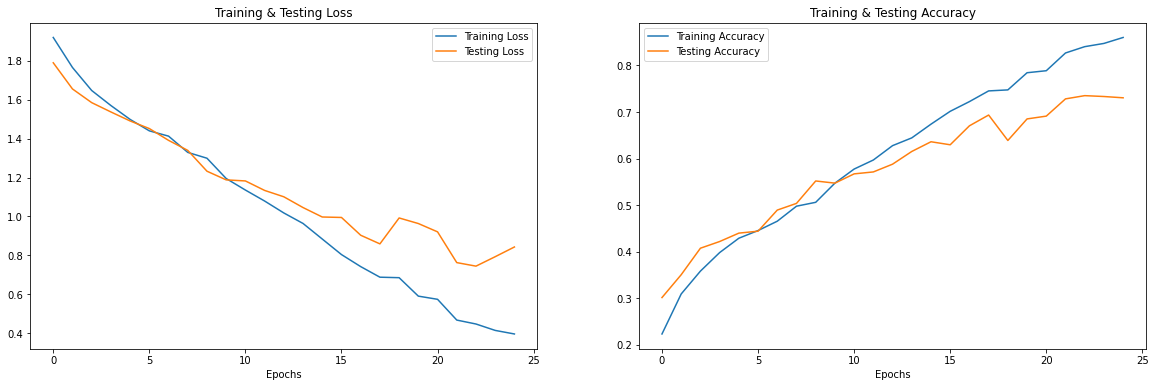

In [48]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [55]:
model.save('model.tf')

INFO:tensorflow:Assets written to: model.tf/assets


In [ ]:
model.

In [49]:
encoder.inverse_transform(model.predict(neutral_res.reshape([1, -1, 1])))

array([['sad']], dtype=object)

In [50]:
encoder.inverse_transform(model.predict(scared_res.reshape([1, -1, 1])))

array([['sad']], dtype=object)

In [51]:
encoder.inverse_transform(model.predict(surprised_res.reshape([1, -1, 1])))

array([['sad']], dtype=object)

In [52]:
encoder.inverse_transform(model.predict(angry_res.reshape([1, -1, 1])))

array([['sad']], dtype=object)

In [56]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [57]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

Predicted Labels Actual Labels
0              calm          calm
1             happy         happy
2              calm       disgust
3           disgust       disgust
4              fear          fear
5             angry         angry
6           disgust       disgust
7          surprise      surprise
8           disgust       disgust
9           disgust       disgust
10             calm           sad
11             calm          calm
12            happy         angry
13             calm          calm
14         surprise      surprise
15             fear          fear
16         surprise         happy
17            angry       disgust
18         surprise      surprise
19         surprise      surprise

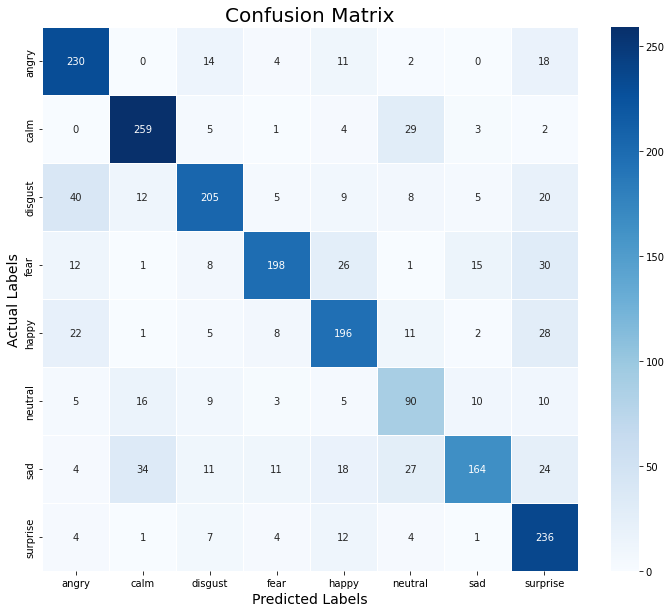

In [58]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.73      0.82      0.77       279
        calm       0.80      0.85      0.83       303
     disgust       0.78      0.67      0.72       304
        fear       0.85      0.68      0.75       291
       happy       0.70      0.72      0.71       273
     neutral       0.52      0.61      0.56       148
         sad       0.82      0.56      0.67       293
    surprise       0.64      0.88      0.74       269

    accuracy                           0.73      2160
   macro avg       0.73      0.72      0.72      2160
weighted avg       0.74      0.73      0.73      2160



### Above we can see that the model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
### Achieved 62% accuracy on our test data, we can improve it more by applying more augmentation techniques and using other feature extraction methods.